# Pathway activity analysis with GEDI

In [1]:
library(ggpubr)
library(cowplot)
library(pheatmap)
library(scuttle)
library(scran)
library(scater)
library(uwot)
library(SingleCellExperiment)
library(ggplot2)
library(HDF5Array)
library(GEDI)
set.seed(43)

Loading required package: ggplot2


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumpr

### Functions

In [2]:
pheatmap.colorsymmetric <- function(x,lim=NULL,...)
{
    require(pheatmap)
    if(is.null(lim)){
        lim <- max(abs(x), na.rm=TRUE)
        if( min(x, na.rm=TRUE) < 0 ){
            lim_down<- -lim
            col_palette<- colorRampPalette(c("blue","white","red"))(256)
        }else{        
            lim_down<- 0
            col_palette<- colorRampPalette(c("white","red"))(256)
        }
    }else{
        lim <- 1
        lim_down<- -1
        col_palette<- colorRampPalette(c("blue","white","red"))(256)        
    }
    pheatmap(
        x, color = col_palette,
        breaks=seq(lim_down,lim,length.out=255), ... )
}

## Inputs

In [3]:
main_dir<- "~/projects/rrg-hsn/lmoral7/splicing-pancancer/thesis_fig_notebooks"
dir_data <- "~/projects/rrg-hsn/lmoral7/splicing-pancancer/data/singlecell_ccRCC/"
dir_gedi_results <- paste0(dir_data,"gedi_models/")

In [5]:
meta <-readRDS(paste0(dir_data, "meta_ccRCC_primary_tumors.rds"))

## Run GEDI

In [ ]:
meta <-readRDS(paste0(dir_data, "meta_ccRCC_primary_tumors.rds"))

umap_res <- readRDS(paste0(dir_data, "umap_res_ccRCC_primary_tumors.rds") ) %>% as.data.frame()
colnames(umap_res)<-c("UMAP1","UMAP2")

sce <- loadHDF5SummarizedExperiment(paste0(dir_data, "my_h5_se/"))
sce <- sce[, rownames(meta)]

In [ ]:
C <- readRDS(paste0(main_dir,"/figures_v3_objects/KIRC.gora_res.C_matrix.RDS"))
dim(C)

#### Preprocess data

In [ ]:
sum_genes<- rowSums(assay(sce, "counts")>5)
genes_use<- sum_genes>3
genes_use<- names(which(genes_use))
sce<- sce[genes_use,]

In [ ]:
# Accesing the raw counts in the SCE object and convert to a sparse Matrix format
raw_counts<- as(as.matrix(assay(sce, "counts")), "dgCMatrix")
commongenes<- intersect(rownames(C), rownames(raw_counts) )
C<- C[commongenes,]
raw_counts<- raw_counts[commongenes,]

In [ ]:
QR <- qr(crossprod(C))
C <- C[ , QR$pivot[seq_len(QR$rank)] ] # remove any columns that results in singularity
dim(C) 

#### Setup GEDI model

In [ ]:
## Set up GEDI model
model <- new("GEDI") # Initialize GEDI object
model$setup(Samples = sce$Sample, # Vector indicating which sample belongs to each cell
            colData = meta, # Metadata (optional)
            M = raw_counts, # Expression data
            C = C, # Gene level prior information
            K = 10, # Number of latent variables to use
            mode = "Bsphere", # Modes to use: Either Bsphere (hyperellipsoid) or Bl2 (hyperplane)
            oi_shrinkage = 1)

#### Fit model

In [ ]:
model$initialize.LVs(randomSeed = 1) # initialize LVs
model$optimize(iterations=200) # run model with 500 iterations
saveRDS( model, file=paste0(main_dir,"/figures_v3_objects/KIRC.gedi.model.rds")) # Saving output model

#### Store results

In [ ]:
# Generating svd
svd_res <- svd.gedi( model )
embedding_res_svd<- svd_res$v %*% diag(svd_res$d)
colnames(embedding_res_svd)<- paste0("embedding", 1:ncol(embedding_res_svd))

# Generating umap of 2 dimensions
umap_2_res <- umap(embedding_res_svd, min_dist=0.01, metric="euclidean")
colnames(umap_2_res)<- paste0("umap", 1:2)
rownames(umap_2_res)<- model$aux$cellIDs
umap_2_res<- data.frame(umap_2_res)

# Reorder meta
meta<- meta[model$aux$cellIDs,] # GEDI reorders the cells by sample, so we need to reorder our original metadata

# Adding UMAP of n dimensions
umap_n_res <- umap( embedding_res_svd, n_components = ncol(embedding_res_svd), min_dist=0.01, metric="euclidean", verbose=F)
colnames(umap_n_res)<- paste0("umap", 1:ncol(embedding_res_svd))
rownames(umap_n_res)<- model$aux$cellIDs
umap_n_res<- data.frame(umap_n_res)        

# Saving results
lis_res<- list(umap_2_res=umap_2_res,               
               umap_n_res=umap_n_res,               
               svd_res=svd_res)
saveRDS(lis_res,file=paste0(main_dir,"/figures_v3_objects/lis_res.rds"))

## Visualize results

In [6]:
gedi_res <- readRDS(paste0(main_dir,"/figures_v3_objects/lis_res.rds"))
model <- readRDS(paste0(main_dir,"/figures_v3_objects/KIRC.gedi.model.rds"))
meta <- meta[model$aux$cellIDs,]
sce <- sce[,rownames(meta)]

ERROR: Error in eval(expr, envir, enclos): object 'sce' not found


In [9]:
tcga.colors<-rev(c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548"))

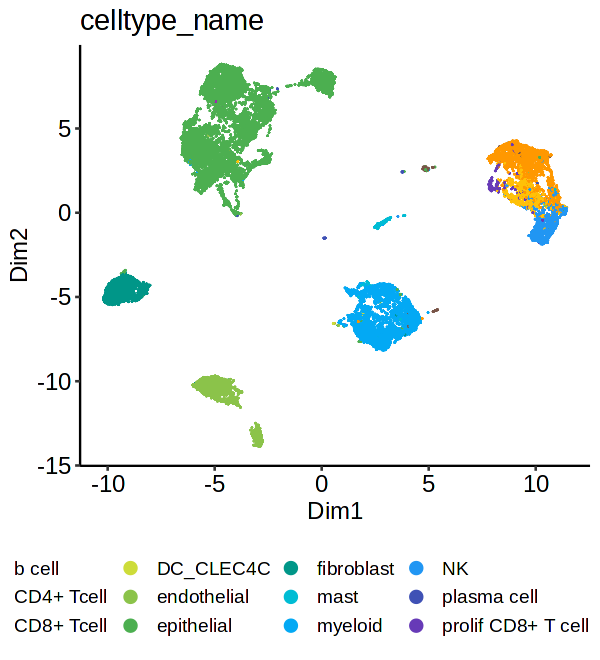

In [10]:
vars_look<- c("simple_Sample", "celltype_name", "infercnv_call", "DF_doublet_call", "log10_sum", "log10_detected", "subsets_mito_percent", "G2M.Score", "S.Score", "Phase", "class", "tumor_site2", "sex", "subtype")
for( var_plot in vars_look[2]){
    p<-ggrastr::rasterise(plot_embedding(gedi_res$umap_2_res, meta[,var_plot]),dpi=500) + 
        labs(title=var_plot) +
        theme_pubr()+
        theme(legend.position="right",text=element_text(size=14))
    
    if(var_plot=="infercnv_call"){
        tn.cols <- c("#8E44AD","#C9C8C8") 
        p<-p+scale_color_manual(values=tn.cols)
    }else if(var_plot=="celltype_name"){
        p<-p+scale_color_manual(values=tcga.colors)+
            theme(legend.position="bottom")+
            labs(color="")
        
    }
    print(p)
    ggsave(p,filename = paste0("../output/figures/gedi_pathways/",var_plot,".pdf"),device="pdf",width = 5.5,height=5,units = "in")
}

#### Heatmap of A matrix

In [11]:
A<- getA.gedi(model) # pathways x lvs
pheatmap.colorsymmetric(A,filename = "../output/figures/gedi_pathways/heatmap_latentvars.pdf",width = 6,height = 3.5)

#### Project activity of pathways

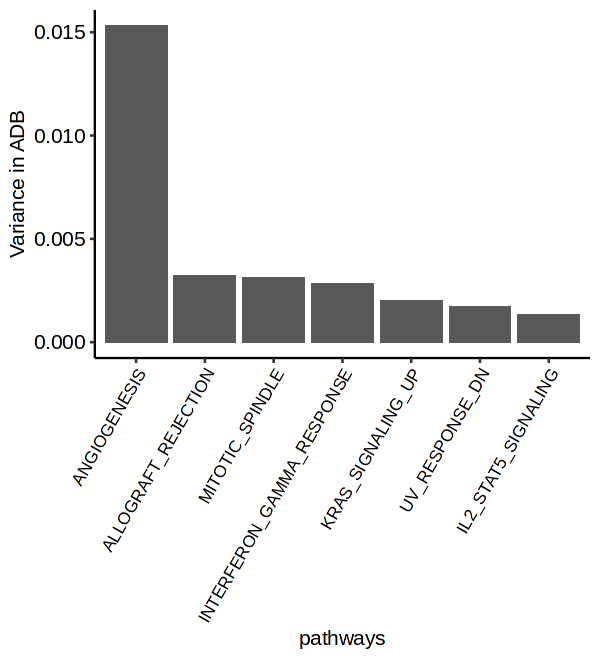

In [12]:
ADB<- getADB.gedi(model) # pathways x cell

rownames(ADB)<- sub("HALLMARK_", "", rownames(ADB) )
var_ADB<- apply(ADB, 1, var)
top_pathways<- names(sort(var_ADB, decreasing=T)[1:7])

ggdat<- data.frame(var_ADB=var_ADB, pathways=names(var_ADB) )

ggdat<- ggdat[ggdat$pathways %in% top_pathways,]
ggdat$pathways<- factor(ggdat$pathways, levels=top_pathways)

g<-ggplot(ggdat,aes(x=pathways, y=var_ADB) ) +
    geom_bar(stat="identity") +
    theme_pubr()+
    theme(axis.text.x=element_text(size=10,angle=60,hjust=1) )+
    labs(y="Variance in ADB")
ggsave(g,filename = "../output/figures/gedi_pathways/pathways_varPlot.pdf",width = 3,height = 3.8,units = "in")
g

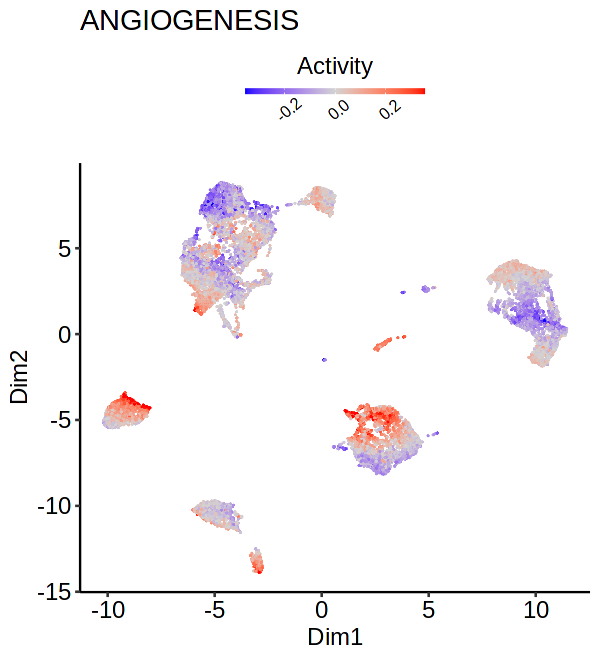

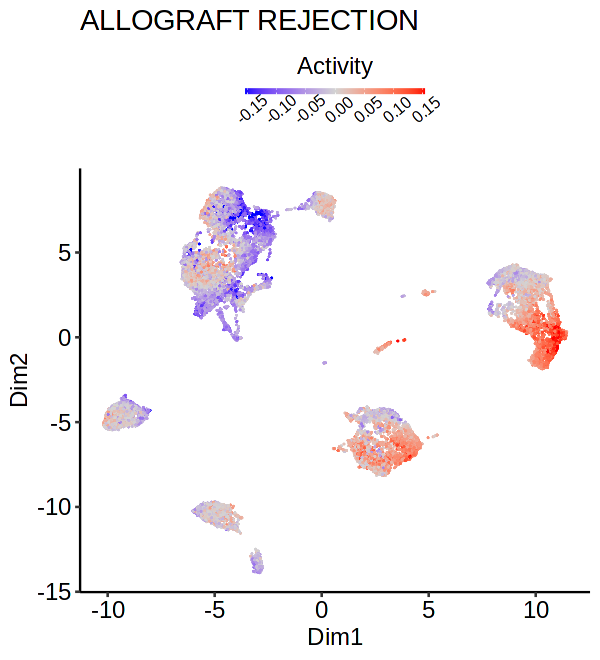

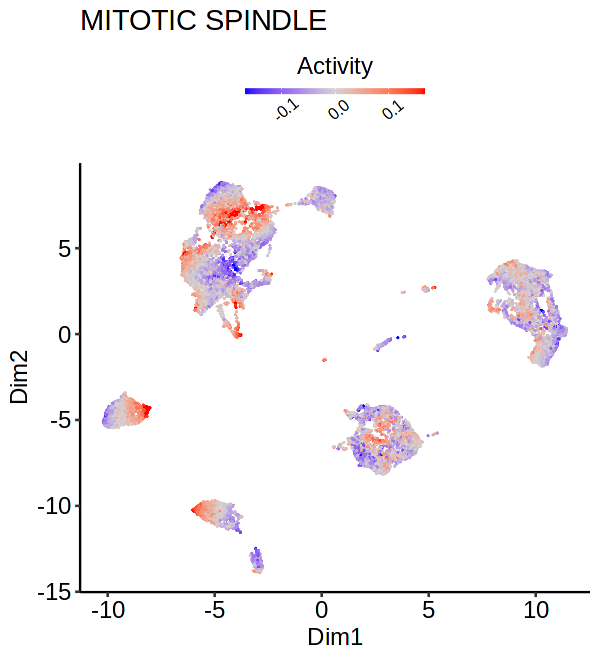

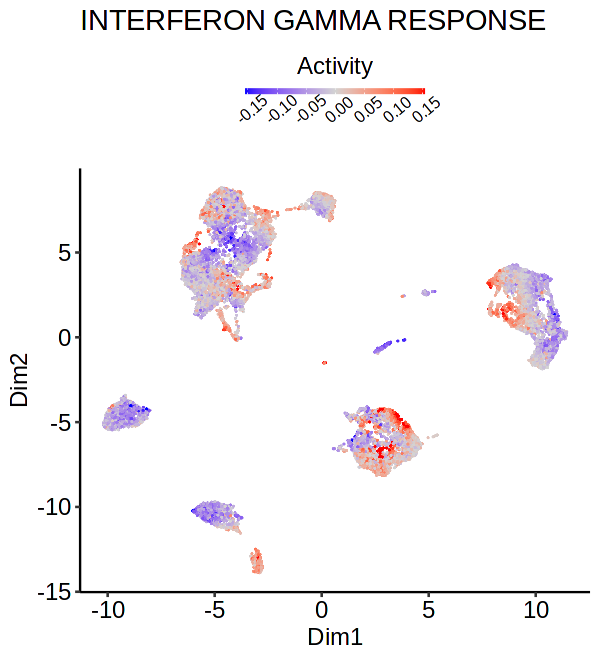

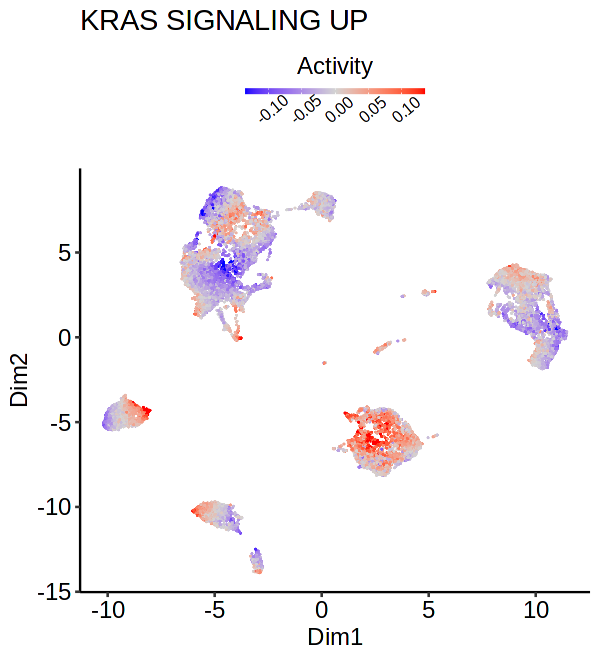

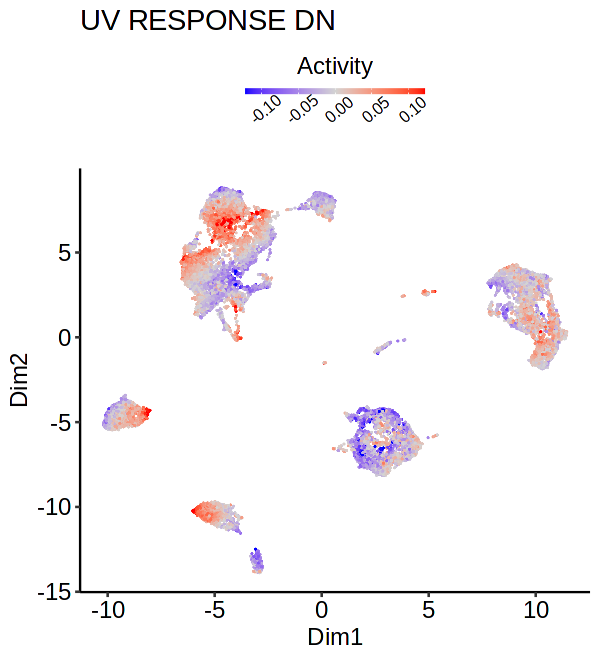

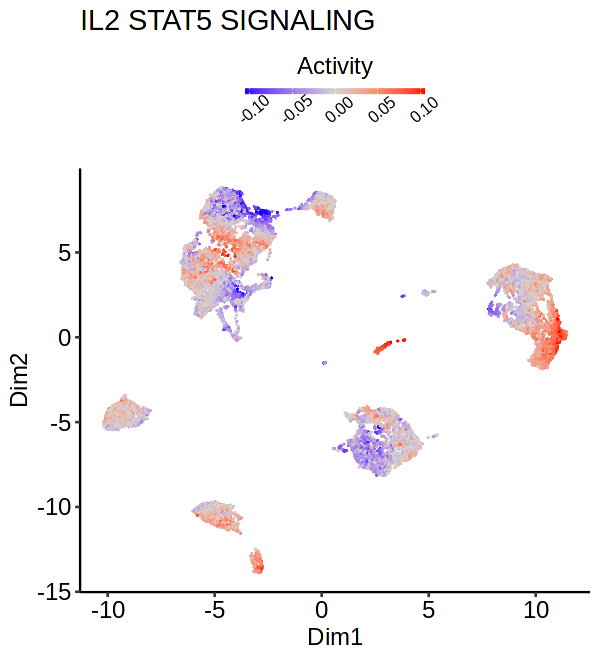

In [13]:
options(repr.plot.width=5,repr.plot.height=5.5)
for(var_plot in top_pathways){
    p<-ggrastr::rasterise(plot_embedding(gedi_res$umap_2_res, ADB[var_plot,]),dpi=500) + 
        labs(title=gsub("_"," ",var_plot),color="Activity") +
        theme_pubr()+
        theme(legend.position = "top",
              text = element_text(size=14))+
        guides(color = guide_colourbar(direction = "horizontal", 
                                         barheight = 0.25,
                                         barwidth = 7.5,
                                         title.position = "top",
                                         title.hjust = 0.5,
                                         label.position = "bottom",
                                         label.theme = element_text(angle = 40,vjust=1,size=9)))
    ggsave(p,filename = paste0("../output/figures/gedi_pathways/",var_plot,".pdf"),device="pdf",width = 5,height=5.5,units = "in")
    print(p)
}